## Mineração de dados - Semana 6: 

### Exercício sobre regras de associação

Use o algoritmo **Apriori** para identificar regras de associação em uma base de dados de compras de uma padaria. Essa padaria é a "The Bread Basket", que fica em Edinburgh, na Escócia. Os dados foram modificados para facilitar o uso neste exercício, e estão disponíveis neste [link](https://raw.githubusercontent.com/higoramario/univesp-com360-mineracao-dados/main/cesta_padaria.csv).

Descrição dos atributos:

* Existem 94 colunas, cada uma corresponde a um produto e cada linha representa uma transação. Quando o produto faz parte de uma transação, a célula recebe o nome do produto, caso contrário o valor é nulo.

Veja uma amostra do conjunto:

| alfajor | baguette | bread | coffee | juice |
| --- | --- | --- | --- | --- | 
| NaN | NaN | bread | coffee | NaN |
| alfajor | NaN | bread | NaN | NaN |
| NaN | NaN | bread | coffee | juice |
| alfajor | baguette | NaN | NaN | NaN |
| ... | ... | ... | ... | ... |

Gere a lista dos itens mais vendidos e menos vendidos. Em seguida, use os valores de suporte de 4% (0.04) e confiança de 40% (0.4) para gerar as regras de associação.

Os dados originais foram retirados do Kaggle, no link a seguir:
[Bread basket](https://www.kaggle.com/code/nandinibagga/apriori-algorithm/data)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (15,10)

Importando a biblioteca apyori e os dados

In [ ]:
!pip -qq install apyori
import apyori

In [ ]:
url = 'https://raw.githubusercontent.com/higoramario/univesp-com360-mineracao-dados/main/cesta_padaria.csv'
transacoes = pd.read_csv(url)
transacoes.head(10)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,5,8,9,10,12,16,18,20,27,31,33,34,36,38,39,41,42,44,46,52,53,54,56,59,63,64,66,67,68,69,70,71,76,80,81,82,84,89,90,92,93) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,adjustment,afternoon with the baker,alfajores,argentina night,art tray,bacon,baguette,bakewell,bare popcorn,basket,...,the bart,the nomad,tiffin,toast,truffles,tshirt,valentine's card,vegan feast,vegan mincepie,victorian sponge
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Tamanho da base de dados

In [ ]:
len(transacoes)

9465

#### Análise exploratória inicial

In [ ]:
itens = transacoes.melt()['value'].dropna().sort_values()
print(f'Existem {itens.nunique()} produtos distintos:\n', itens.unique())

Existem 94 produtos distintos:
 ['adjustment' 'afternoon with the baker' 'alfajores' 'argentina night'
 'art tray' 'bacon' 'baguette' 'bakewell' 'bare popcorn' 'basket'
 'bowl nic pitt' 'bread' 'bread pudding' 'brioche and salami' 'brownie'
 'cake' 'caramel bites' 'cherry me dried fruit' 'chicken sand'
 'chicken stew' 'chimichurri oil' 'chocolates' 'christmas common' 'coffee'
 'coffee granules' 'coke' 'cookies' 'crepes' 'crisps'
 'drinking chocolate spoons' 'duck egg' 'dulce de leche' 'eggs'
 "ella's kitchen pouches" 'empanadas' 'extra salami or feta' 'fairy doors'
 'farm house' 'focaccia' 'frittata' 'fudge' 'gift voucher'
 'gingerbread syrup' 'granola' 'hack the stack' 'half slice monster'
 'hearty & seasonal' 'honey' 'hot chocolate' 'jam' 'jammie dodgers'
 'juice' 'keeping it local' 'kids biscuit' 'lemon and coconut' 'medialuna'
 'mighty protein' 'mineral water' 'mortimer' 'muesli' 'muffin'
 'my-5 fruit shoot' 'nomad bag' 'olum & polenta' 'panatone' 'pastry'
 'pick and mix bowls' 'pi

#### Itens mais vendidos

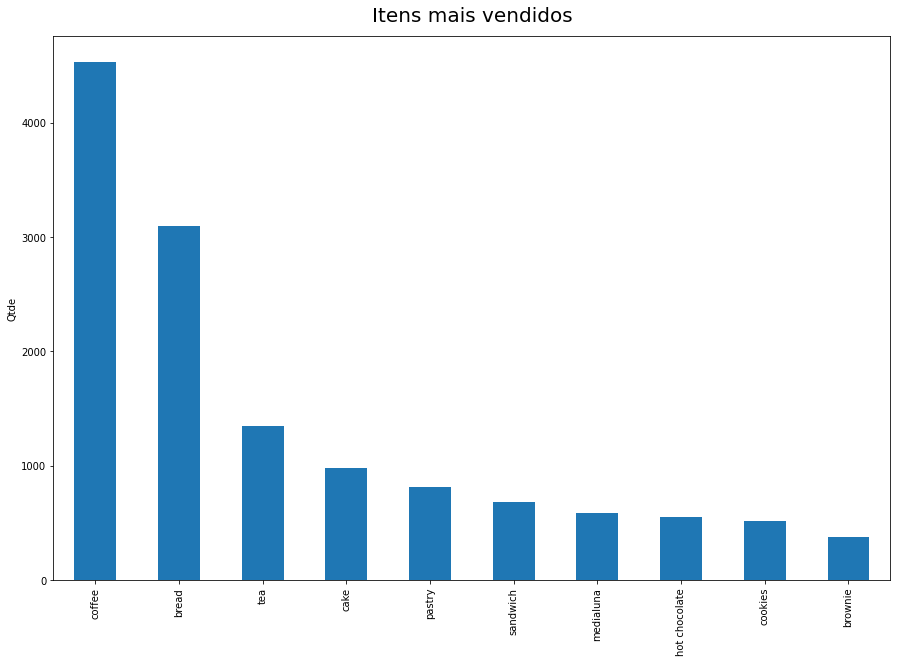

In [ ]:
qtde_itens = itens.value_counts()

ax = qtde_itens.nlargest(10).plot(kind="bar")
ax.set_title("Itens mais vendidos", size=20, weight=500, pad=15)
ax.set_ylabel("Qtde")
plt.show()

#### Itens menos vendidos

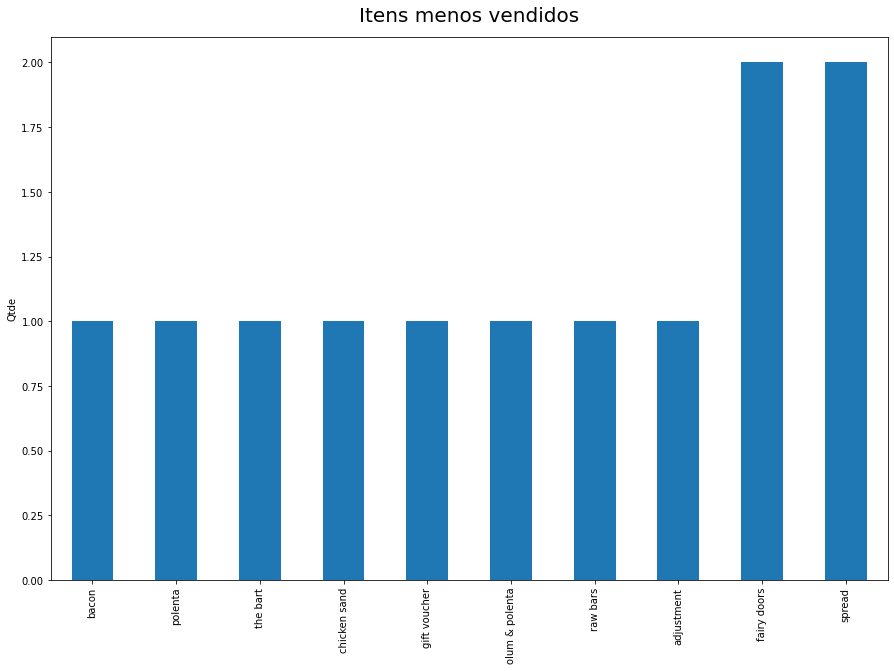

In [ ]:
ax = qtde_itens.nsmallest(10).plot(kind="bar")
ax.set_title("Itens menos vendidos", size=20, weight=500, pad=15)
ax.set_ylabel("Qtde")
plt.show()

#### Pré-processamento 
##### Contando os itens de cada transação

In [ ]:
#conta a qtde de itens não nulos em cada objeto
qtde_por_cesta = transacoes.notna().apply(sum, axis=1)

#### No Apriori é necessário haver ao menos 2 itens em cada transação, então eliminamos transações com um único produto

In [ ]:
#separando os objetos com mais de um item na transação
cestas = [set(linha.dropna()) for _, linha in transacoes[qtde_por_cesta > 1].iterrows()]
cestas[:5]

[{'cookies', 'hot chocolate', 'jam'},
 {'bread', 'coffee', 'pastry'},
 {'medialuna', 'muffin', 'pastry'},
 {'coffee', 'medialuna', 'pastry', 'tea'},
 {'bread', 'pastry'}]

In [ ]:
len(cestas)

5517

#### Rodando o Apriori

In [ ]:
minsup = 0.04
minconf = 0.4
regras_associacao = apyori.apriori(cestas, min_support=minsup, min_confidence=minconf)

for regra in regras_associacao:
  itens = list(regra.items)
  print(
      f"{itens[:-1]} --> [{itens[-1]}]  Suporte: {regra.support:.3f}"
      f"  Confiança: {regra.ordered_statistics[0].confidence:.3f}"
  )

[] --> [coffee]  Suporte: 0.604  Confiança: 0.604
['bread'] --> [coffee]  Suporte: 0.154  Confiança: 0.447
['coffee'] --> [cake]  Suporte: 0.094  Confiança: 0.586
['cookies'] --> [coffee]  Suporte: 0.048  Confiança: 0.568
['hot chocolate'] --> [coffee]  Suporte: 0.051  Confiança: 0.580
['medialuna'] --> [coffee]  Suporte: 0.060  Confiança: 0.631
['coffee'] --> [pastry]  Suporte: 0.082  Confiança: 0.600
['coffee'] --> [sandwich]  Suporte: 0.066  Confiança: 0.591
['coffee'] --> [tea]  Suporte: 0.086  Confiança: 0.412
['toast'] --> [coffee]  Suporte: 0.041  Confiança: 0.737


Os resultados obtidos no seu exercício devem semelhantes aos apresentados neste caderno. Confira e compare os resultados. 

Experimente outros valores de suporte e confiança e veja os resultados. Tente usar outras bases de dados e também o algoritmo FP-Growth e veja as diferenças.